# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('dark_background')

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

In [2]:
train = pd.read_csv(os.path.join('data','train.csv'))
test = pd.read_csv(os.path.join('data','test.csv'))
submission = pd.read_csv(os.path.join('data','sample_submission.csv'))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           float64
 1   signal         float64
 2   open_channels  int64  
dtypes: float64(2), int64(1)
memory usage: 114.4 MB


In [4]:
train.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


# Downsampling

In [5]:
train['open_channels'].value_counts().sort_values().reset_index(drop=True)[0]

35733

In [6]:
train['open_channels'].value_counts().min()

35733

In [7]:
index_kept = []

In [8]:
for c in train['open_channels'].unique():
    index_kept += list(np.random.choice(np.where(train['open_channels'] == c)[0], train['open_channels'].value_counts().min(), replace=False))

In [9]:
len(set(index_kept)) == train['open_channels'].value_counts().min() * 11

True

In [14]:
all_train = train.copy()

In [15]:
train = all_train.loc[index_kept,:].reset_index(drop=True)

In [16]:
train.shape

(393063, 3)

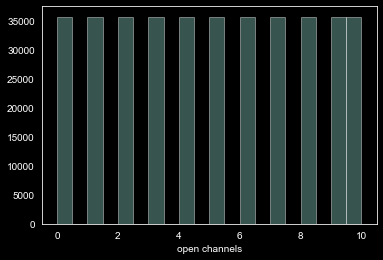

In [17]:
sns.distplot(train['open_channels'], kde=False, bins=20, axlabel='open channels')
plt.show()

# Classical ML models without downsampling

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(train[['time','signal']], train['open_channels'], stratify=train['open_channels'], test_size=0.2)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import f1_score

In [41]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('K-Nearest Neighbors', KNeighborsClassifier()))
models.append(('Decision Trees', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBoost', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))
names = []
for name,model in models:
    names.append(name)

In [42]:
def cv_results(X, y, models):
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=3, shuffle=True)
        cv_results = model_selection.cross_val_predict(model, X, y, cv=kfold)
        results.append(f1_score(y,cv_results, average='macro'))
        msg = "%s: %f" % (name, f1_score(y,cv_results, average='macro'))
        print(msg)
    return(results)

In [43]:
results = cv_results(X_train, y_train, models)

C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\fatma\anaconda3\e

Logistic Regression: 0.295302
K-Nearest Neighbors: 0.922309
Decision Trees: 0.897324
Random Forest: 0.922609
XGBoost: 0.928813
LGBM: 0.922552


Results:  
 - Logistic Regression: 0.295302
 - K-Nearest Neighbors: 0.922309
 - Decision Trees: 0.897324
 - Random Forest: 0.922609
 - XGBoost: 0.928813
 - LGBM: 0.922552

## Fine Tuning

### Light Gradient Boosting Machines

In [44]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [45]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [46]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 10

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='f1_macro',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [47]:
gs.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's multi_logloss: 0.23932
[200]	valid's multi_logloss: 0.212585
[300]	valid's multi_logloss: 0.205452
[400]	valid's multi_logloss: 0.202923
[500]	valid's multi_logloss: 0.20147
[600]	valid's multi_logloss: 0.200685
[700]	valid's multi_logloss: 0.200296
[800]	valid's multi_logloss: 0.200065
[900]	valid's multi_logloss: 0.199924
[1000]	valid's multi_logloss: 0.199842
Early stopping, best iteration is:
[1011]	valid's multi_logloss: 0.199824
Training until validation scores don't improve for 30 rounds
[100]	valid's multi_logloss: 0.240022
[200]	valid's multi_logloss: 0.212124
[300]	valid's multi_logloss: 0.205256
[400]	valid's multi_logloss: 0.202307
[500]	valid's multi_logloss: 0.200755
[600]	valid's multi_logloss: 0.200022
[700]	valid's multi_logloss: 0.199614
[800]	valid's multi_logloss: 0.199367
[900]	valid's multi_logloss: 0.199224
[1000]	valid's multi_logloss: 0.199101
[1100]	valid's multi_logloss: 0.199063
Early

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 140.4min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's multi_logloss: 0.280929
[200]	valid's multi_logloss: 0.224075
[300]	valid's multi_logloss: 0.207798
[400]	valid's multi_logloss: 0.202055
[500]	valid's multi_logloss: 0.199273
[600]	valid's multi_logloss: 0.197925
[700]	valid's multi_logloss: 0.197235
[800]	valid's multi_logloss: 0.197017
Early stopping, best iteration is:
[864]	valid's multi_logloss: 0.196887


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='None', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=5000, n_jobs=4,
                                            num_leaves=31, objective=None,
                                            random_state=314, reg_alpha=0.0,
                                            reg_la...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018C8C854D

In [48]:
gs.best_params_

{'colsample_bytree': 0.7271985991098294,
 'min_child_samples': 212,
 'min_child_weight': 0.01,
 'num_leaves': 13,
 'reg_alpha': 0.1,
 'reg_lambda': 5,
 'subsample': 0.44782056066342807}

In [49]:
gs.best_score_

0.9232918310229546

In [50]:
best_params = {'colsample_bytree': 0.7271985991098294,
 'min_child_samples': 212,
 'min_child_weight': 0.01,
 'num_leaves': 13,
 'reg_alpha': 0.1,
 'reg_lambda': 5,
 'subsample': 0.44782056066342807}

In [51]:
best_lgbm = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, **best_params)

In [52]:
best_lgbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7271985991098294, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=212, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=13, objective=None,
               random_state=314, reg_alpha=0.1, reg_lambda=5, silent=True,
               subsample=0.44782056066342807, subsample_for_bin=200000,
               subsample_freq=0)

In [53]:
y_train_pred = best_lgbm.predict(X_train)

In [54]:
f1_score(y_train_pred, y_train, average='macro')

0.9301092990083362

In [55]:
y_val_pred = best_lgbm.predict(X_val)

In [56]:
f1_score(y_val_pred, y_val, average='macro')

0.9221053570769187

### KNN

In [57]:
params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform','distance'],
}

In [64]:
clf_knn = KNeighborsClassifier(n_jobs=-1)
gs_knn = GridSearchCV(
    estimator=clf_knn,
    param_grid=params_knn, 
    scoring='f1_macro',
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=-1)

In [69]:
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=True)

In [70]:
gs_knn.best_score_

0.9258335740148405

In [71]:
gs_knn.best_params_

{'n_neighbors': 13}

In [72]:
best_knn = KNeighborsClassifier(n_neighbors=13)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [73]:
y_train_pred = best_knn.predict(X_train)

In [74]:
f1_score(y_train_pred, y_train, average='macro')

0.9345778467431952

In [75]:
y_val_pred = best_knn.predict(X_val)

In [76]:
f1_score(y_val_pred, y_val, average='macro')

0.9275308530379334

### XGBoost

In [25]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [21]:
n_HP_points_to_test = 10

In [22]:
fit_params_xgb = {"early_stopping_rounds":30, 
            "eval_metric" : 'mlogloss', 
            "eval_set" : [(X_val,y_val)],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100}

In [23]:
param_xgb = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
}

In [26]:
clf_xgb = XGBClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs_xgb = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_xgb, 
    n_iter=n_HP_points_to_test,
    scoring='f1_macro',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs_xgb.fit(X_train, y_train, **fit_params_xgb)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-mlogloss:2.39648
Will train until validation_0-mlogloss hasn't improved in 30 rounds.
[100]	validation_0-mlogloss:2.25639
[200]	validation_0-mlogloss:2.14084
[300]	validation_0-mlogloss:2.04339
[400]	validation_0-mlogloss:1.95802
[500]	validation_0-mlogloss:1.88217
[600]	validation_0-mlogloss:1.81474
[700]	validation_0-mlogloss:1.75361
[800]	validation_0-mlogloss:1.69810
[900]	validation_0-mlogloss:1.64657
[1000]	validation_0-mlogloss:1.59939
[1100]	validation_0-mlogloss:1.55556
[1200]	validation_0-mlogloss:1.51547
[1300]	validation_0-mlogloss:1.47805
[1400]	validation_0-mlogloss:1.44332
[1500]	validation_0-mlogloss:1.41094
[1600]	validation_0-mlogloss:1.38075
[1700]	validation_0-mlogloss:1.35206
[1800]	validation_0-mlogloss:1.32509
[1900]	validation_0-mlogloss:1.29991
[2000]	validation_0-mlogloss:1.27612
[2100]	validation_0-mlogloss:1.25392
[2200]	validation_0-mlogloss:1.23267
[2300]	validation_0-mlogloss:1.21257
[2400]	validation_0-mlogloss:1.19378
[2500]	validation_